# Лабораторная работа №6. Многоскоростная обработка сигналов.
Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ

#  Модуль 3. Особенности реализации многоскоростных систем.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

##  Полифазные структуры многоскоростных систем.

### Полифазная структура однократной интерполяции

Заменим КИХ-фильтр с передаточной функцией $H(z)$ работающий на высокой частоте дискретизации (${\tilde{f}_{\text{д}}}=L{f}_{\text{д}}=L/\Delta t$) в схеме 

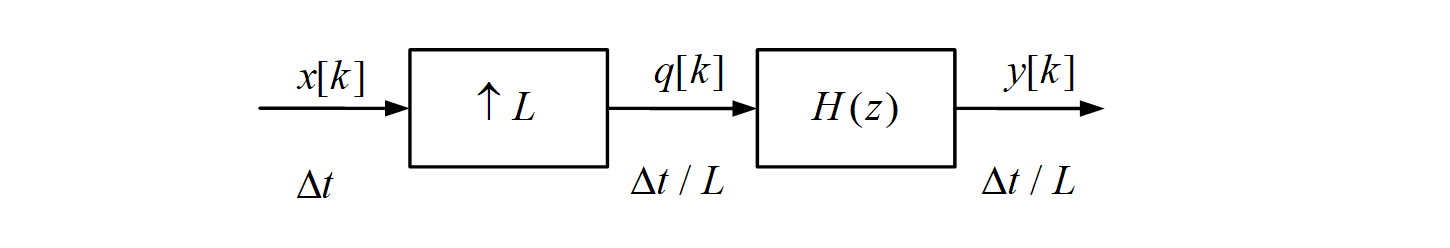


эквивалентной структурой более простых КИХ-фильтров, работающих на низкой частоте дискретизации. Пусть импульсная характеристика КИХ-фильтра имеет $N$ отсчетов и пусть  $G=N/L$ — целое число. Тогда
$$H(z)=\sum\limits_{k=0}^{N-1}{h[k]{{z}^{-k}}}=\sum\limits_{m=0}^{L-1}{\sum\limits_{k=0}^{G-1}{h\left[ Lk+m \right]{{z}^{-(Lk+m)}}}}=\sum\limits_{m=0}^{L-1}{{{z}^{-m}}\sum\limits_{k=0}^{G-1}{h\left[ Lk+m \right]{{z}^{-Lk}}}}$$
Обозначим $h\left[ Lk+m \right]={{\tilde{h}}_{m}}[k]$,   ${{\tilde{H}}_{m}}(z)=\sum\limits_{k=0}^{G-1}{{{{\tilde{h}}}_{m}}[k]{{z}^{-k}}}$
Тогда 
$$\sum\limits_{k=0}^{G-1}{h\left[ Lk+m \right]{{z}^{-Lk}}}=\sum\limits_{k=0}^{G-1}{{{{\tilde{h}}}_{m}}[k]{{z}^{-Lk}}}={{\tilde{H}}_{m}}({{z}^{L}})$$
$$H(z)=\sum\limits_{m=0}^{L-1}{{{z}^{-m}}{{{\tilde{H}}}_{m}}({{z}^{L}})}$$


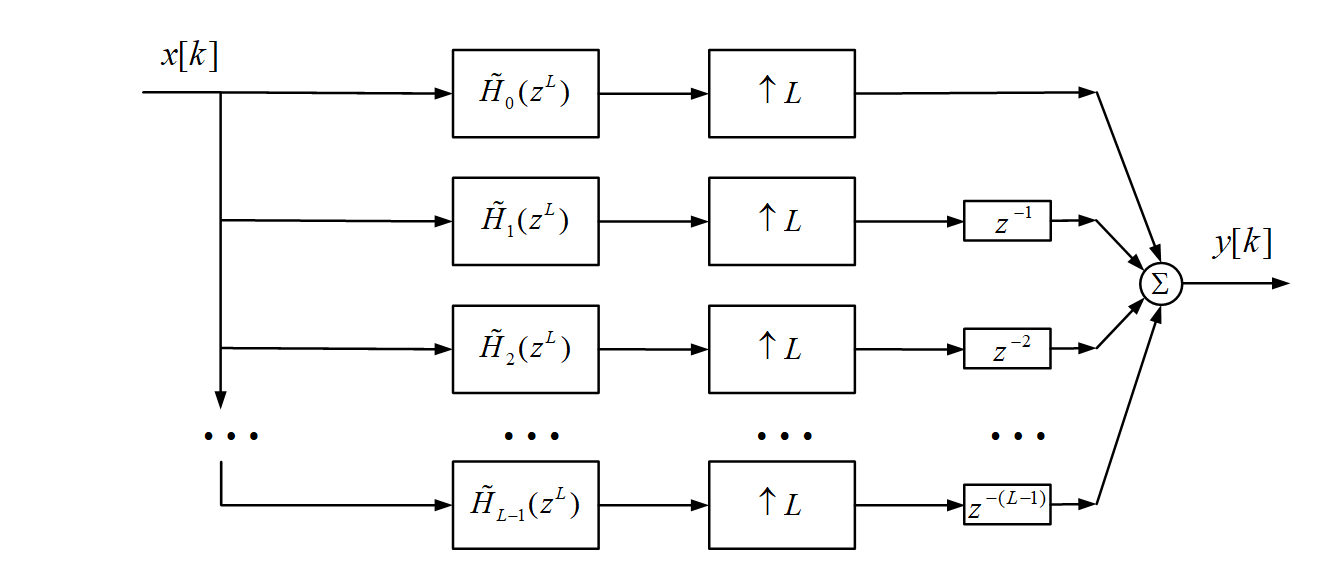

В полифазной структуре однократной интерполяции вычисления проводятся в три этапа [1]:

1) Фильтрация сигнала с частотой дискретизации ${{f}_{\text{д}}}<{\tilde{f}_{\text{д}}}$ (для достаточно больших $L$ выполняется ${{f}_{\text{д}}}\ll {\tilde{f}_{\text{д}}}$). Передаточные функции полифазных фильтров ${{\tilde{H}}_{m}}(z)$, $m=0,\;1,\;\dots, L-1.$


2) Переход к частоте дискретизации  ${\tilde{f}_{\text{д}}}$. 

3) Формирование выходного сигнала. Сигналы каждой линии задерживаются на требуемое число отсчетов, после чего все результаты суммируются.


### Пример. Интерполяция сигнала с помощью полифазной структуры.
Пусть $L=5$, $x[k]=\cos\left( 2\pi \nu_0 k\right)$, $\nu_0=1/10$,  $0 \le k < 32 $.


In [2]:
L=5
Nx=32
nu0=1/10
k=np.arange(Nx)
x=np.cos(2*np.pi*nu0*k)

Получим импульсную характеристику КИХ-фильтра для однофазной системы $h[k]$. Воспользуемся методом равномерной Чебышёвской аппроксимации синтеза КИХ-фильтров. 
* В полосе пропускания $\nu \in [-1/(2L), 1/(2L)]$ коэффициент усиления идеального фильтра должен быть равен $L$, для реального $\approx L$.  
* Для реального фильтра вблизи точек оси частот $-1/(2L)$, $1/(2L)$ зададим узкую полосу перехода. 
* Отметим, что ширина этой полосы при неизменном числе отсчетов импульсной характеристики может влиять на величину пульсаций АЧХ в полосе перехода и в полосе задерживания.

In [3]:
N=40
nu1=1/(2*L)-0.02 #0.05
nu2=1/(2*L)+0.02 #0.05
bands = np.array([0, nu1, nu2, 0.5])
desired = np.array([L, 0])
weight = np.array([1, 1])
h_pm = signal.remez(numtaps=N, bands=bands, desired=desired, weight=weight, fs=1)

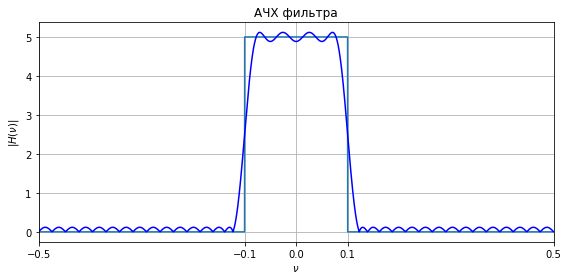

In [4]:
H=np.fft.fftshift(np.fft.fft(h_pm, 2048))
nu=np.arange(H.size)/H.size-0.5
plt.figure(figsize=[8, 4])
dl=1e-4
plt.plot([-0.5, -1/(2*L)-dl, -1/(2*L)+dl, 1/(2*L)-dl, 1/(2*L)+dl, 0.5], [0, 0, L, L, 0, 0], 'C0')
plt.plot(nu, abs(H), 'b')
plt.xticks([-0.5, -1/(2*L), 0, 1/(2*L), 0.5])
plt.xlim([-0.5, 0.5])
plt.xlabel("$\\nu$")
plt.ylabel("|$H(\\nu)|$")
plt.title("АЧХ фильтра")
plt.grid()
plt.tight_layout()

In [5]:
G=int(N/L)
G

8

Определим импульсные характеристики фильтров, работающих на частое дискретизации входного сигнала $f_д=\tilde{f}_д / L$ по правилу
 $${{\tilde{h}}_{m}}[k]=h\left[ Lk+m \right], \;\; 0\le m <L.$$

In [6]:
h=np.zeros([L, G])
for m in range(L):
    h[m]=np.array(h_pm[m:N:L])

In [7]:
x_filtered=np.zeros([L, L*(x.size+G-1)])
for m in range(L):
    x_filtered[m][m::L]=signal.convolve(x, h[m])
y = sum(x_filtered[:])

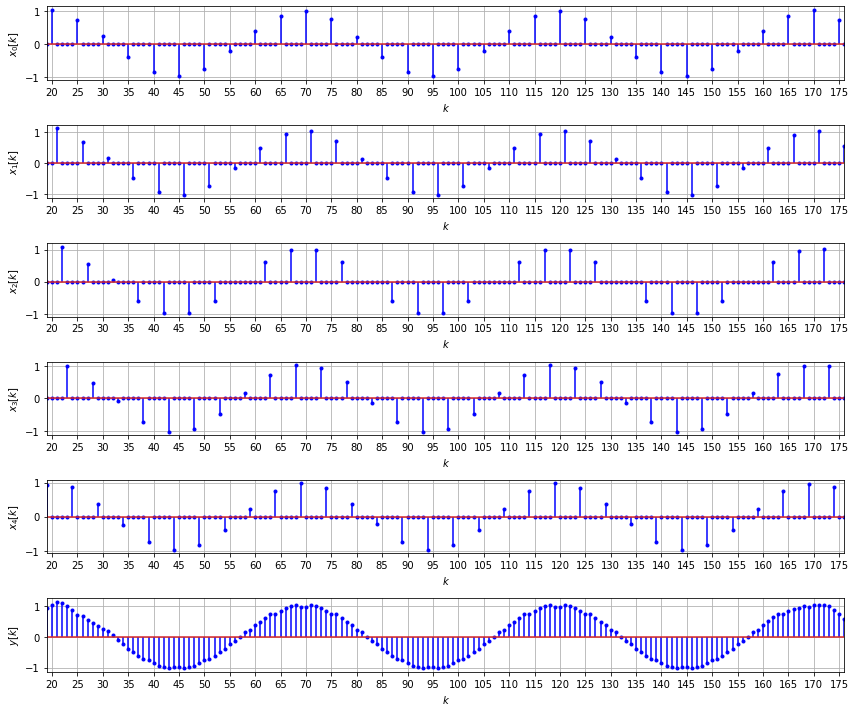

In [8]:
plt.figure(figsize=[12, 10])
k=np.arange(L*(x.size+G-1))
xsize=L*(x.size+G-1)
for m in range(L):
    plt.subplot(L+1, 1, m+1)
    plt.stem(k, x_filtered[m], 'b', markerfmt='b.', use_line_collection=True)
    plt.grid()
    plt.xticks(k[::L])
    plt.xlim([(N-1)//2, xsize-(N-1)//2])
    plt.xlabel("$k$")
    plt.ylabel("$x_%i[k]$" %m)
    
    
plt.subplot(L+1, 1, L+1)
plt.stem(k, y, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
plt.xticks(k[::L])
plt.xlim([(N-1)//2, xsize-(N-1)//2])
plt.xlabel("$k$")
plt.ylabel("$y[k]$")
plt.tight_layout()

### scipy.signal.resample_poly
```scipy.signal.resample_poly(x, up, down, axis=0, window=('kaiser', 5.0), padtype='constant', cval=None)```
Resample x along the given axis using polyphase filtering.
The signal x is upsampled by the factor up, a zero-phase low-pass FIR filter is applied, and then it is downsampled by the factor down. The resulting sample rate is up / down times the original sample rate. By default, values beyond the boundary of the signal are assumed to be zero during the filtering step.

**Parameters**

* ```x``` *array_like*
The data to be resampled.
* ```up``` *int*
The upsampling factor.
* ```down``` *int*
The downsampling factor.
* ```axis``` *int, optional*
The axis of x that is resampled. Default is 0. 

* ```window``` *string, tuple, or array_like, optional* Desired window to use to design the low-pass filter, or the FIR filter coefficients to employ. See below for details.

**Returns**

* ```resampled_x``` array The resampled array.

In [9]:
L = 5
Nx = 32
nu0 = 1/10
k = np.arange(Nx)
x = np.cos(2*np.pi*nu0*k)
y = signal.resample_poly(x, up=L, down=1, window=h_pm/L)

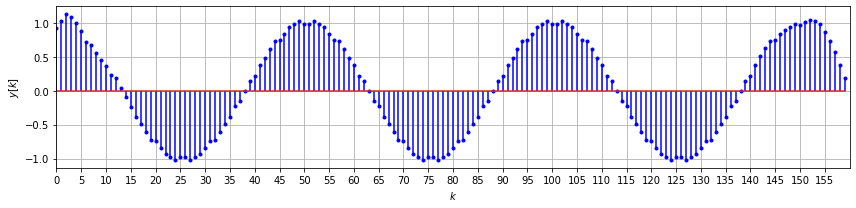

In [10]:
plt.figure(figsize=[12, 3])
k=np.arange(y.size)
plt.stem(k, y, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
plt.xticks(k[::L])
plt.xlim([0, y.size])
plt.xlabel("$k$")
plt.ylabel("$y[k]$")
plt.tight_layout()

### Полифазная структура однократной децимации

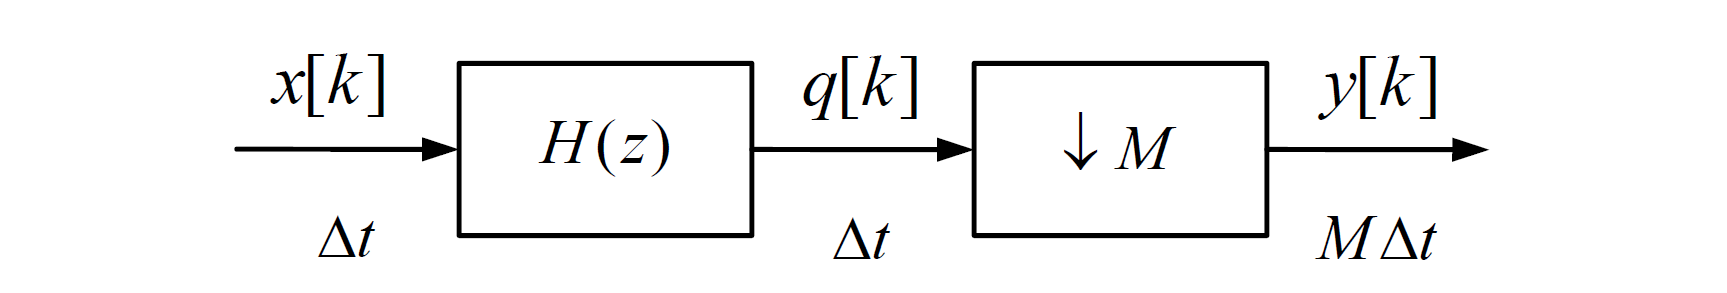

В обычной реализации в системе однократной децимации цифровой фильтр  также работает на высокой частоте дискретизации ${f}_{\text{д}}=M {\tilde{f}_{\text{д}}}$. Если это КИХ-фильтр, то, используя полифазную структуру, его также можно заменить на набор КИХ-фильтров, работающих на низкой частоте дискретизации ${\tilde{f}_{\text{д}}}={f}_{\text{д}}/ M$.

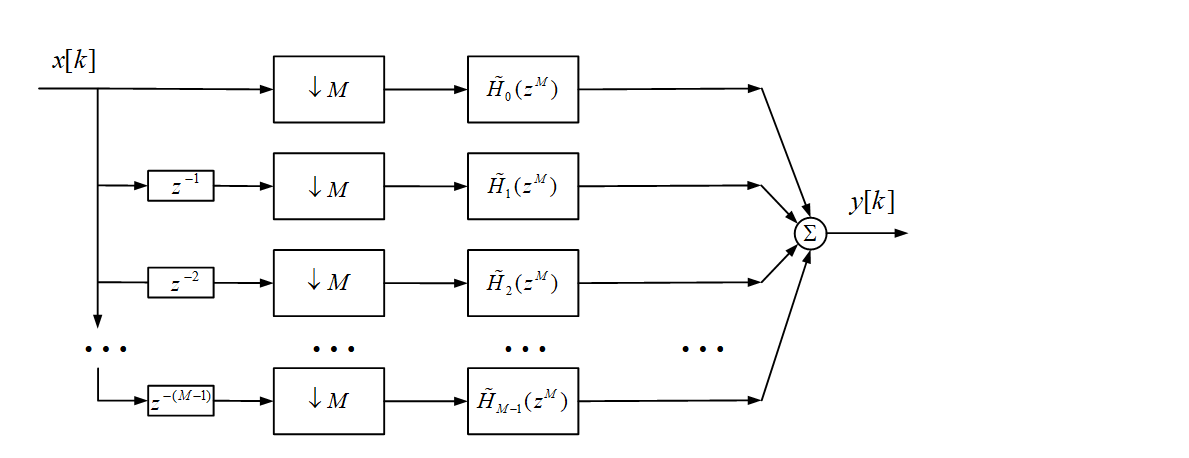

 В полифазной структуре однократной децимации вычисления проводятся в четыре этапа:

1) С помощью блоков задержки формируются входные сигналы каждой линии полифазной структуры. В каждой следующей линии на вход поступает сигнал, задержанный на еще один такт дискретизации входного сигнала $\Delta t$. Входные сигналы каждой линии имеют вид:
$$x_m[k]=x[Mk-m], \;\; m=0,\;1,\;\dots, M-1.$$ 
2) Блоки компрессоров $\downarrow \ M$ выполняют в каждой линии оставляют только каждый $M$-ый отсчет. 

3) Фильтрация сигналов с частотой дискретизации ${\tilde{f}_{\text{д}}}={f}_{\text{д}}/ M$ в каждой линии. Импульсные харакетеристики фильтров
$$\tilde{h}_m[k]=h[Mk+m].$$

4) Формирование выходного сигнала. Суммируются выходные сигналы всех линий.


### Пример. Децимация сигнала с помощью полифазной структуры.
Пусть $M=3$, $x[k]=\cos\left( 2\pi \nu_0 k\right)+\varepsilon[k]$, $\;\;\varepsilon[k]=0.05 \cos\left( 2\pi \nu_1 k\right)$, $\;\nu_0=1/40$,  $\;\nu_0=0,35$, $\;0 \le k < 63 $.


In [11]:
M=3
Nx=63
nu0=1/40
nu1=0.35
k=np.arange(Nx)
x=np.cos(2*np.pi*nu0*k)+0.05*np.cos(2*np.pi*nu1*k)

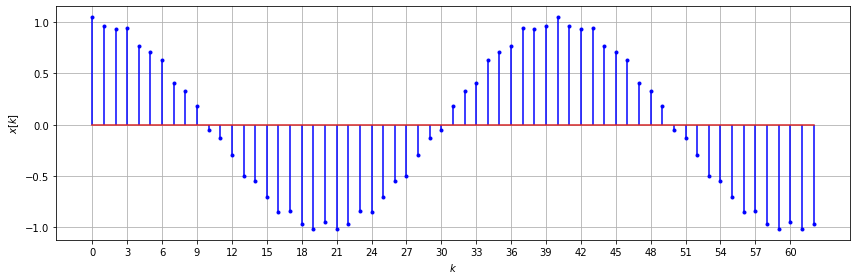

In [12]:
plt.figure(figsize=[12, 4])
k=np.arange(Nx)
plt.stem(k, x, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
plt.xticks(k[::M])
plt.xlabel("$k$")
plt.ylabel("$x[k]$")
plt.tight_layout()

Получим импульсную характеристику КИХ-фильтра для однофазной системы $h[k]$. Воспользуемся методом равномерной Чебышёвской аппроксимации синтеза КИХ-фильтров. 
* В полосе пропускания $\nu \in [-1/(2M), 1/(2M)]$ коэффициент усиления идеального фильтра должен быть равен $1$, для реального $\approx 1$.  
* Для реального фильтра вблизи точек оси частот $-1/(2M)$, $1/(2M)$ зададим узкую полосу перехода. 
* Отметим, что ширина этой полосы при неизменном числе отсчетов импульсной характеристики может влиять на величину пульсаций АЧХ в полосе перехода и в полосе задерживания.

In [13]:
N=60
nu1=1/(2*M)-0.02
nu2=1/(2*M)+0.02
bands = np.array([0, nu1, nu2, 0.5])
desired = np.array([1, 0])
weight = np.array([1, 1])
h_pm = signal.remez(numtaps=N, bands=bands, desired=desired, weight=weight, fs=1)

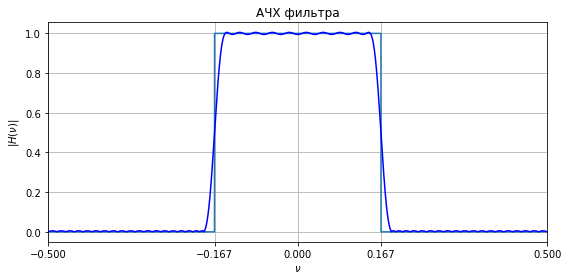

In [14]:
H=np.fft.fftshift(np.fft.fft(h_pm, 2048))
nu=np.arange(H.size)/H.size-0.5
plt.figure(figsize=[8, 4])
dl=1e-4
plt.plot([-0.5, -1/(2*M)-dl, -1/(2*M)+dl, 1/(2*M)-dl, 1/(2*M)+dl, 0.5], [0, 0, 1, 1, 0, 0], 'C0')
plt.plot(nu, abs(H), 'b')
plt.xticks([-0.5, -1/(2*M), 0, 1/(2*M), 0.5])
plt.xlim([-0.5, 0.5])
plt.xlabel("$\\nu$")
plt.ylabel("|$H(\\nu)|$")
plt.title("АЧХ фильтра")
plt.grid()
plt.tight_layout()

In [15]:
G=int(N/M)
G

20

Определим импульсные характеристики фильтров, работающих на частоте дискретизации входного сигнала $\tilde{f}_д= f_д/ M$ по правилу
 $${{\tilde{h}}_{m}}[k]=h\left[ Mk+m \right], \;\; 0\le m <M.$$

In [16]:
h=np.zeros([M, G])
for m in range(M):
    h[m]=np.array(h_pm[m:N:M])

In [17]:
x.shape

(63,)

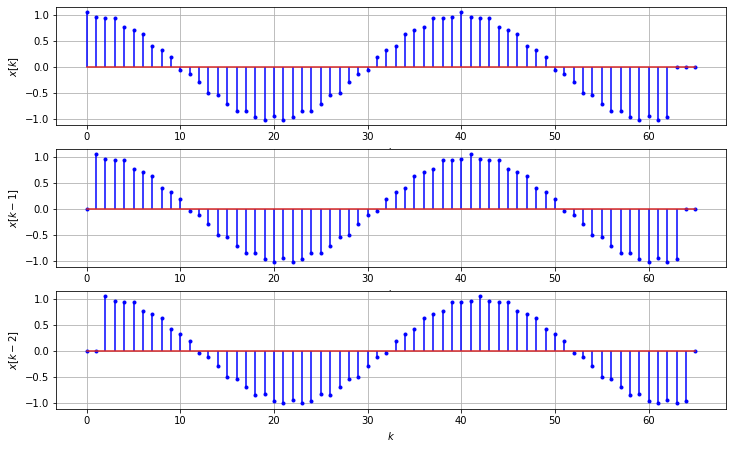

In [18]:
x_shifted=np.zeros([M, Nx+M])
for m in range(M):
    x_shifted[m, m:(m+len(x))]=x

plt.figure(figsize=[12, 10])
k=np.arange(M*(x.size+G-1))
xsize=M*(x.size+G-1)
for m in range(M):
    plt.subplot(M+1, 1, m+1)
    plt.stem(np.arange(len(x_shifted[m])), x_shifted[m], 'b', markerfmt='b.', use_line_collection=True)
    plt.grid()
    #plt.xticks(k[::M])
    #plt.xlim([(N-1)//2, xsize-(N-1)//2])
    plt.xlabel("$k$")
    str1="-%i" %m if m!=0 else ""
    plt.ylabel("$x[k"+str1+"]$")

In [19]:
x_compressed=x_shifted[:, 0::M]

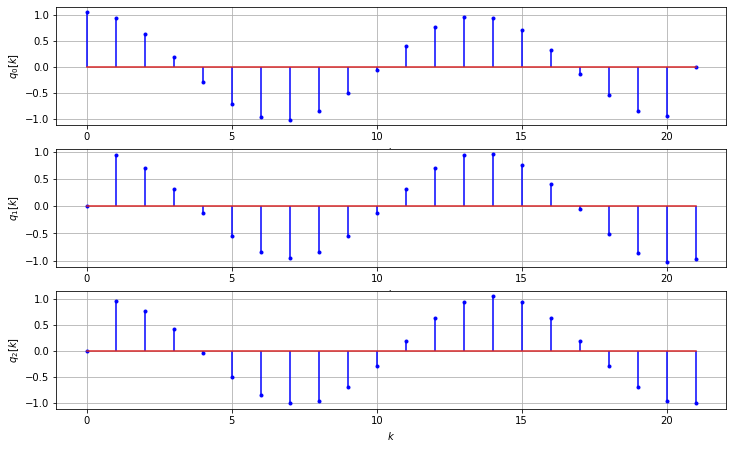

In [20]:
plt.figure(figsize=[12, 10])
for m in range(M):
    plt.subplot(M+1, 1, m+1)
    plt.stem(np.arange(len(x_compressed[m])), x_compressed[m], 'b', markerfmt='b.', use_line_collection=True)
    plt.grid()
    plt.xlabel("$k$")
    plt.ylabel("$q_%i[k]$" %m)

In [21]:
x_filtered=np.zeros([M, x_compressed[0].size+h[0].size-1])
for m in range(M):
    x_filtered[m]=signal.convolve(x_compressed[m], h[m])
y = sum(x_filtered[:])

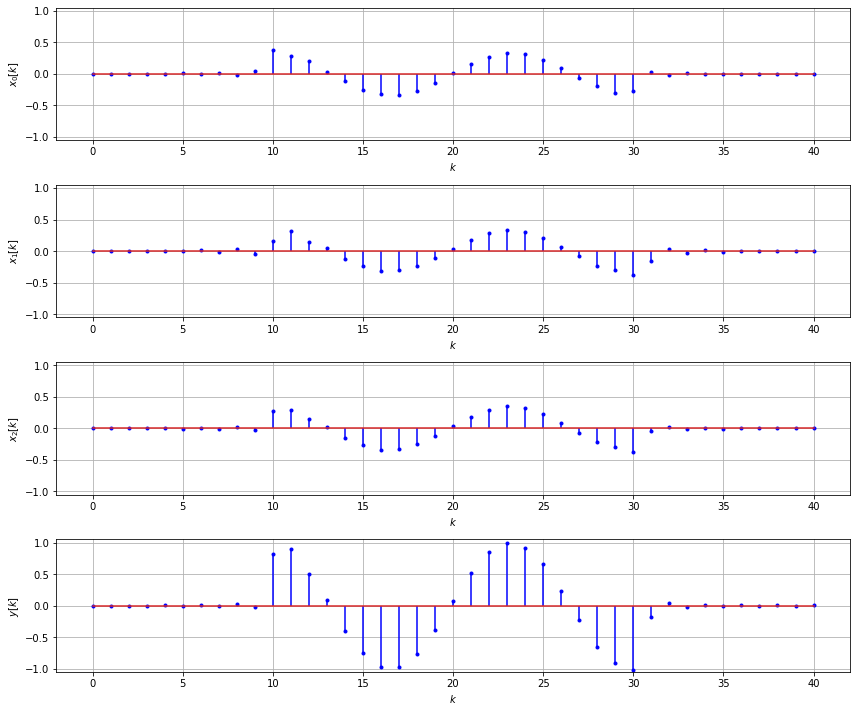

In [22]:
plt.figure(figsize=[12, 10])
k=np.arange(M*(x.size+G-1))
xsize=M*(x.size+G-1)
for m in range(M):
    plt.subplot(M+1, 1, m+1)
    plt.stem(np.arange(len(x_filtered[m])), x_filtered[m], 'b', markerfmt='b.', use_line_collection=True)
    plt.grid()
    #plt.xticks(k[::M])
    #plt.xlim([(N-1)//2, xsize-(N-1)//2])
    plt.xlabel("$k$")
    plt.ylabel("$x_%i[k]$" %m)
    plt.ylim([-1.05, 1.05])
    
    
plt.subplot(M+1, 1, M+1)
plt.stem(np.arange(len(y)), y, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$y[k]$")
plt.ylim([-1.05, 1.05])
plt.tight_layout()

Сравним с выходом однофазной системы.

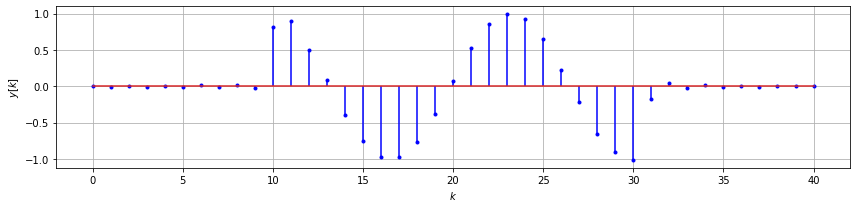

In [23]:
y2=signal.upfirdn(x=x, down=M, h=h_pm)
plt.figure(figsize=[12, 3])
k=np.arange(y2.size)
plt.stem(k, y, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
#plt.xticks(k[::L])
#plt.xlim([0, y2.size])
plt.xlabel("$k$")
plt.ylabel("$y[k]$")
plt.tight_layout()

## CIC-фильтры в задачах интерполяции и децимации.

### CIC-фильтр однокаскадный (без учета умножителя на $1/N$)


Блок-схема в прямой транспонированной форме 

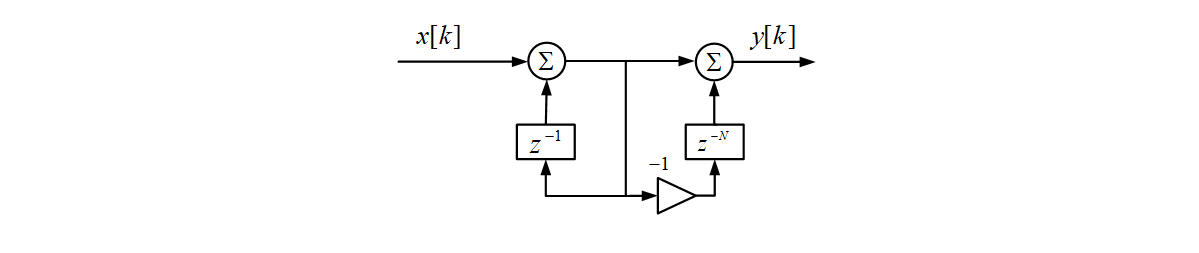

Импульсная характеристика
$${{h}_{1}}[k]=\sum\limits_{m=0}^{N-1}{\mathbf{1}}[k-m].$$

Передаточная функция
$${{H}_{1}}\left( z \right)=\sum\limits_{m\,=\,0}^{N-1}{{{h}_{m}}}{{z}^{-m}}=1+{{z}^{-1}}+{{z}^{-2}}+.\text{ }\text{. }\text{. }{{z}^{-(N-1)}}=\frac{1-{{z}^{-N}}}{1-{{z}^{-1}}}.$$

Частотная характеристика
$${{H}_{1}}\left( \theta  \right)=\exp \left( -j\theta \frac{N-1}{2} \right)\frac{\sin \left( \frac{\theta N}{2} \right)}{\sin \left( \frac{\theta }{2} \right)}$$





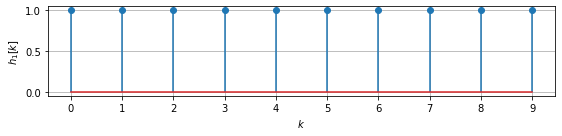

In [24]:
N=10
h1=np.ones(N)
plt.figure(figsize=[8, 2])
plt.stem(np.arange(h1.size), h1, use_line_collection=True)
plt.xticks(np.arange(h1.size))
plt.xlabel("$k$")
plt.ylabel("$h_1[k]$")
plt.grid()
plt.tight_layout()

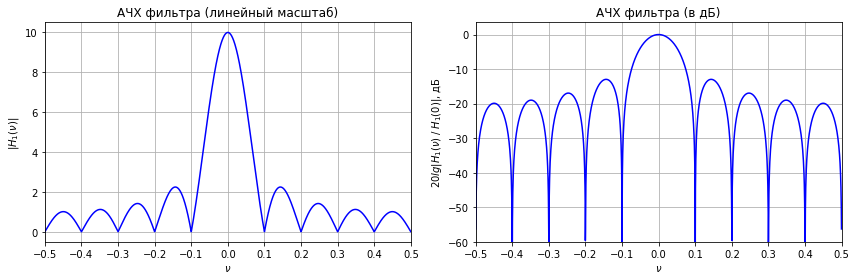

In [25]:
H1=np.fft.fftshift(np.fft.fft(h1, 2048))
nu=np.arange(H1.size)/H1.size-0.5
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(nu, abs(H1), 'b')
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("|$H_1(\\nu)|$")
plt.title("АЧХ фильтра (линейный масштаб)")
plt.grid()
plt.subplot(1, 2, 2)
with np.errstate(divide='ignore'):
    plt.plot(nu, 20*np.log10(abs(H1)/max((abs(H1)))), 'b')
plt.xlim([-0.5, 0.5])
plt.ylim(bottom=-60)
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("$20 lg|H_1(\\nu)\;/\;H_1(0)|$, дБ")
plt.title("АЧХ фильтра (в дБ)")
plt.grid()
plt.tight_layout()

### CIC-фильтр двухкаскадный (без учета умножителя на $1/N$)



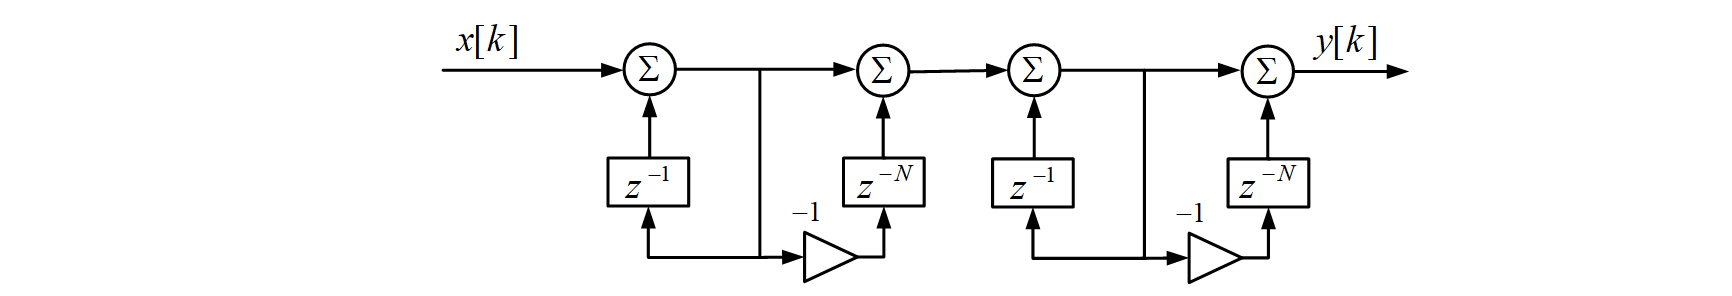

Импульсная характеристика
$${{h}_{2}}[k]={{h}_{1}}[k]\otimes {{h}_{1}}[k]$$
Передаточная функция
$${{H}_{2}}\left( z \right)={{H}_{1}}\left( z \right){{H}_{1}}\left( z \right)={{\left( \frac{1-{{z}^{-N}}}{1-{{z}^{-1}}} \right)}^{2}}$$ 
АЧХ        
    $$\left| {{H}_{2}}\left( \theta  \right) \right|=\frac{{{\sin }^{2}}\left( \frac{\theta N}{2} \right)}{{{\sin }^{2}}\left( \frac{\theta }{2} \right)}.$$


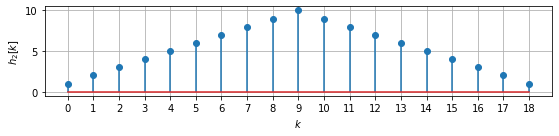

In [26]:
N = 10
h1 = np.ones(N)
h2 = signal.convolve(h1, h1)
plt.figure(figsize=[8, 2])
plt.stem(np.arange(h2.size), h2, use_line_collection=True)
plt.xticks(np.arange(h2.size))
plt.xlabel("$k$")
plt.ylabel("$h_2[k]$")
plt.grid()
plt.tight_layout()

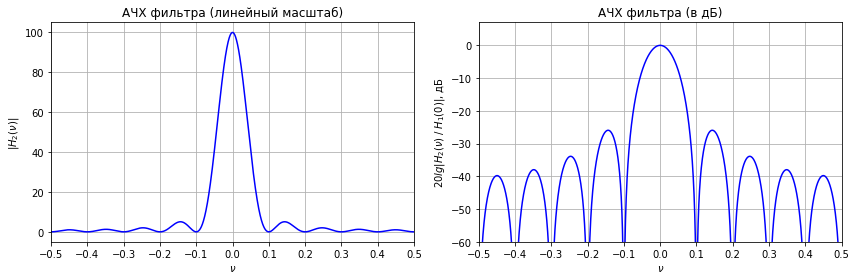

In [27]:
H2=np.fft.fftshift(np.fft.fft(h2, 2048))
nu=np.arange(H2.size)/H2.size-0.5
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(nu, abs(H2), 'b')
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("|$H_2(\\nu)|$")
plt.title("АЧХ фильтра (линейный масштаб)")
plt.grid()
plt.subplot(1, 2, 2)
with np.errstate(divide='ignore'):
    plt.plot(nu, 20*np.log10(abs(H2)/max((abs(H2)))), 'b')
plt.xlim([-0.5, 0.5])
plt.ylim(bottom=-60)
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("$20 lg|H_2(\\nu)\;/\;H_1(0)|$, дБ")
plt.title("АЧХ фильтра (в дБ)")
plt.grid()
plt.tight_layout()

### Двухкаскадный фильтр в системе однократной децимации (без учета умножителя на $1/N$)

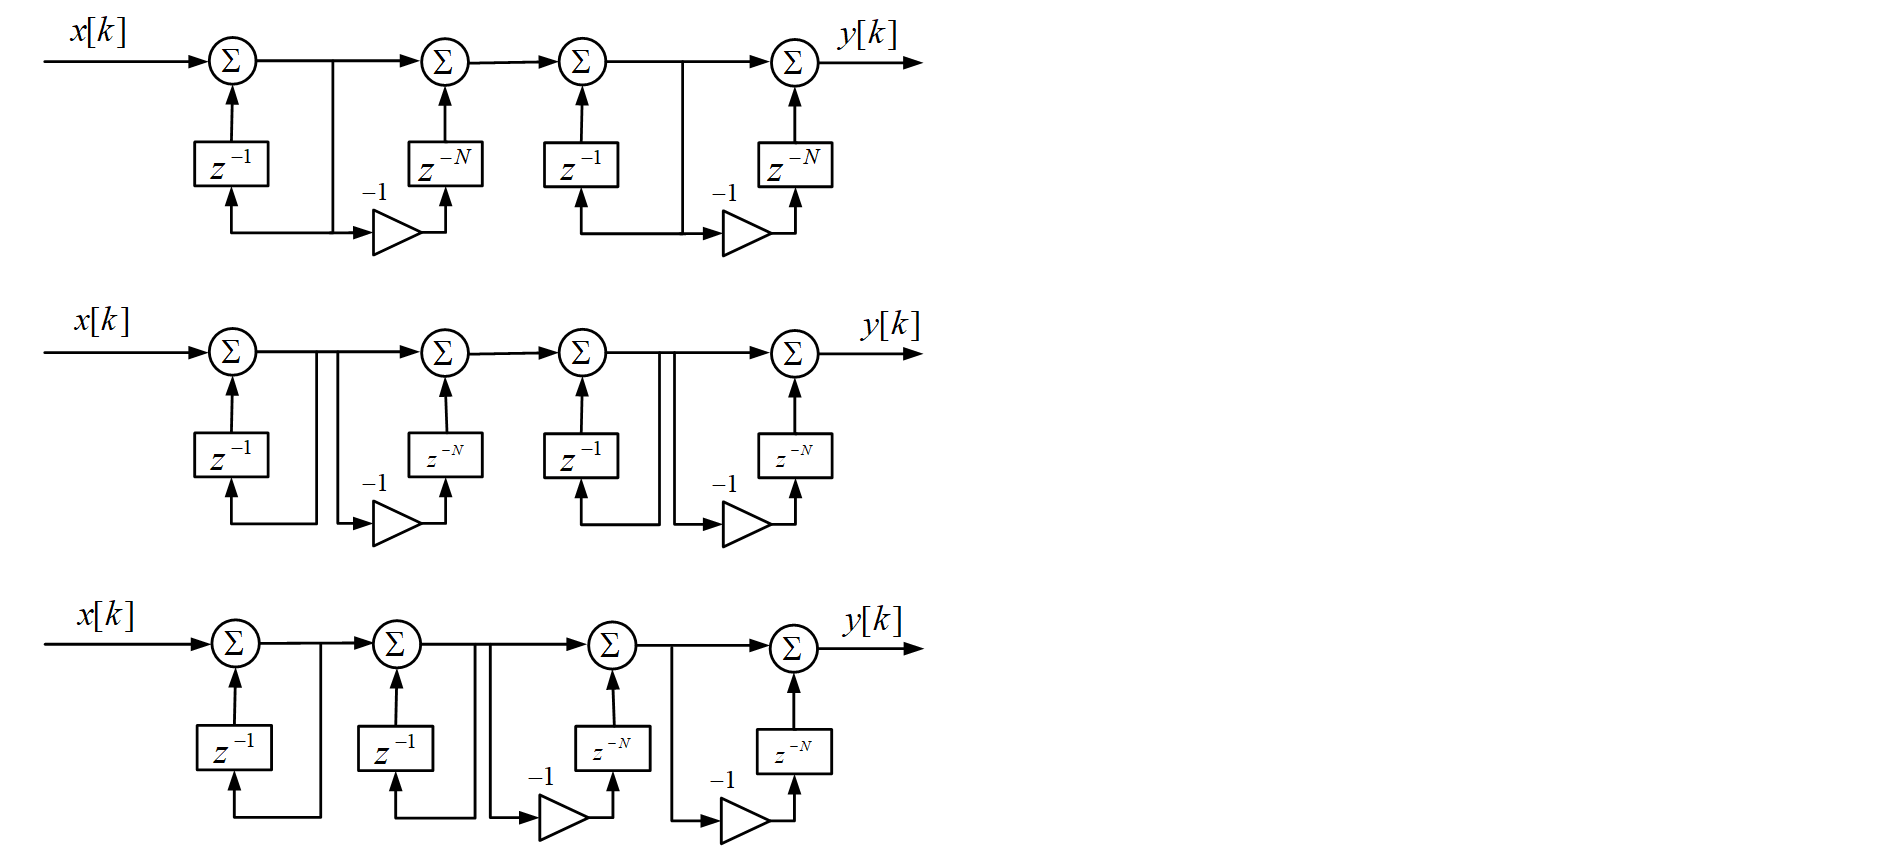

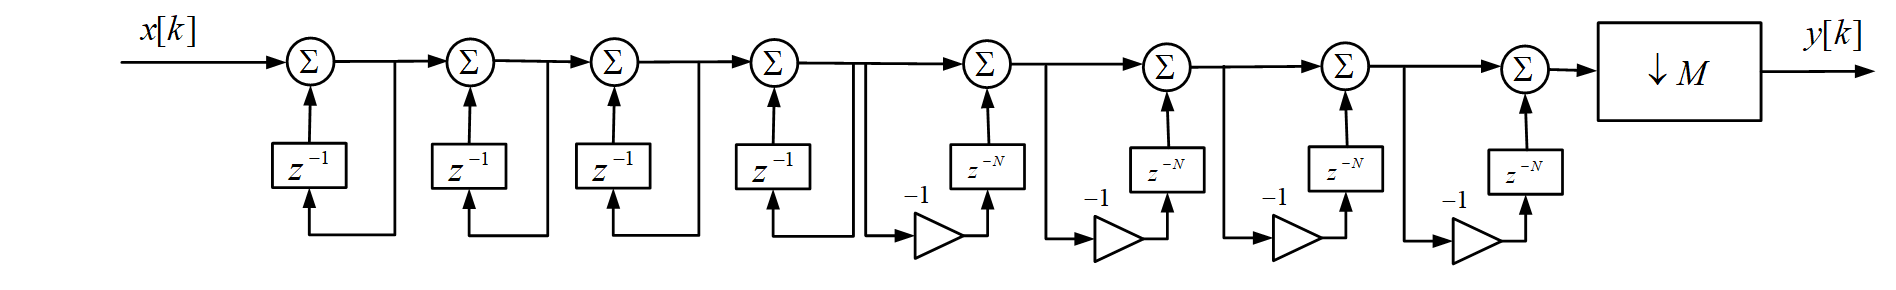

Изменим позицию блока компрессора $\downarrow M$. Заметим, что следующие две схемы эквивалентны. 

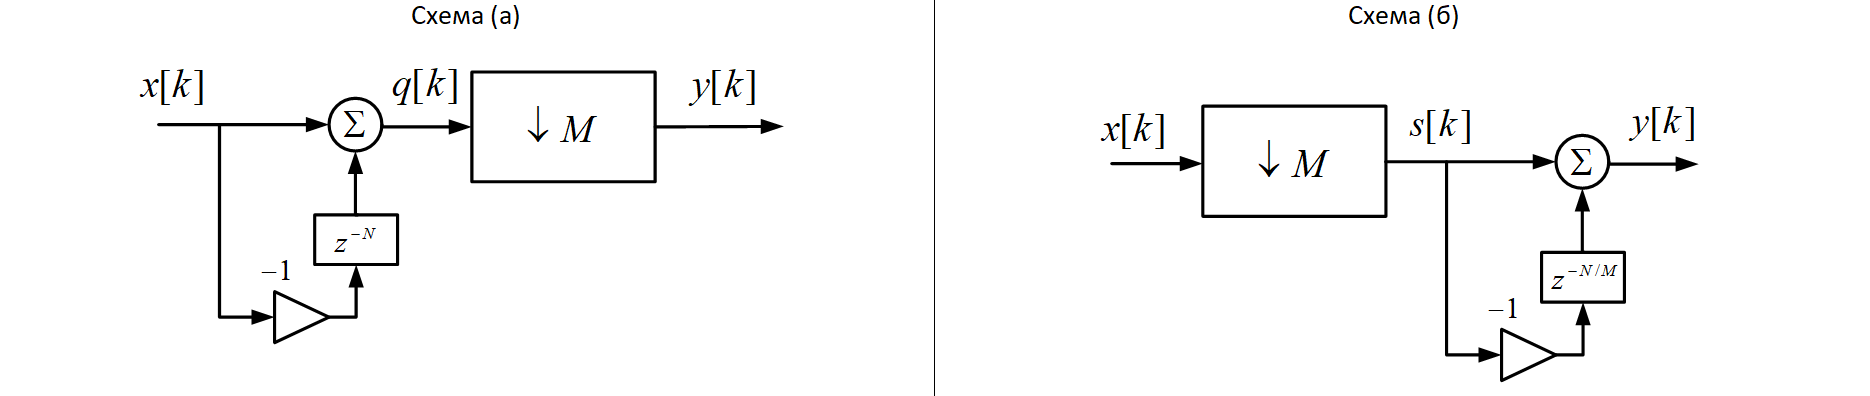

Для схемы (а):
$$q[k]=x[k]-x[k-N]$$
$$y[k]=q[kM]$$
$$y[k]=x[kM]- x[kM-N]$$

Для схемы (б):
если $N/M$— целое, то 
$$y[k]=s[k]-s[k-N/M]$$
$$s[k]=x[kM]$$


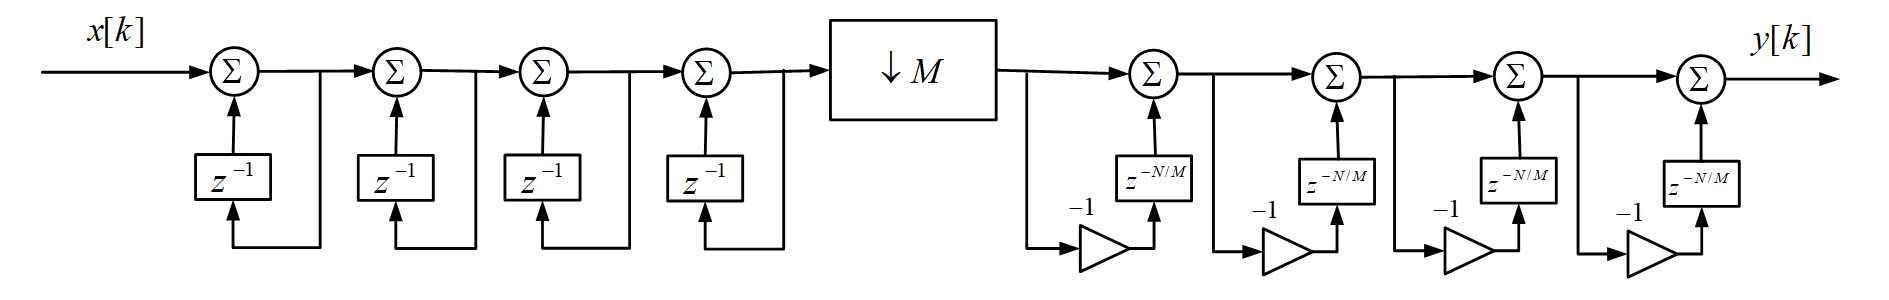

Если частоту среза фильтра поместить в первый нуль АЧХ, то $${{\nu }_{c}}=\frac{1}{2M}=\frac{1}{N}.$$  Тогда $N/M=2$.

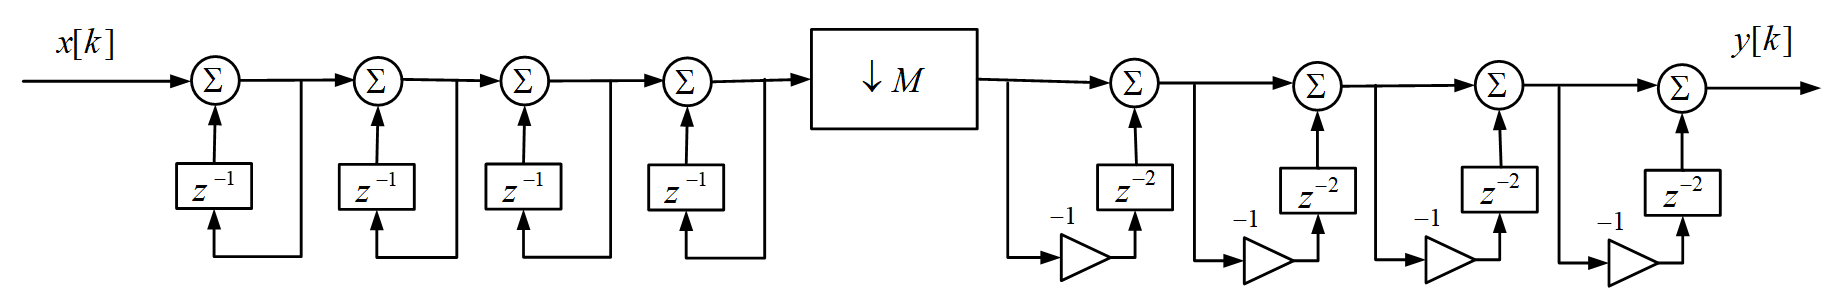

### Пример.
Пусть $M=3$, $x[k]=\cos\left( 2\pi \nu_0 k\right)+0.5 \cos\left( 2\pi \nu_1 k\right)$, $\;\nu_0=1/40$,  $\;\nu_0=1/30$, $\;0 \le k < 128 $.


In [28]:
M=3
Nx=128
nu0=1/20
nu1=1/30
k=np.arange(Nx)
x=np.cos(2*np.pi*nu0*k)+0.5*np.cos(2*np.pi*nu1*k)

In [29]:
N=2*M
N

6

$$ [\beta_0, \beta_1, \beta_2, 1, \alpha_1, \alpha_2]$$

$$ [a_0, a_1, a_2, 1, -b_1, -b_2]$$

Для физически реализуемой дискретной LTI–системы разностное уравнение может быть записано в виде 
$$\sum\limits_{m=0}^{M}{{{\alpha }_{m}}}y[k-m]=\sum\limits_{m=0}^{N-1}{{{\beta }_{m}}}x[k-m],$$
где $\alpha_m$ и $\beta_m$ – заданные коэффициенты, $M$ и $N$ – натуральные числа. Как правило, полагают ${{\alpha }_{0}}=1$.


In [30]:
n_sections=4
second_order_section1=np.zeros((n_sections, 6), dtype=float)
second_order_section1[:, 0]=1.0
second_order_section1[:, 3]=1.0
second_order_section1[:, 4]=-1.0
second_order_section1

array([[ 1.,  0.,  0.,  1., -1.,  0.],
       [ 1.,  0.,  0.,  1., -1.,  0.],
       [ 1.,  0.,  0.,  1., -1.,  0.],
       [ 1.,  0.,  0.,  1., -1.,  0.]])

In [31]:
second_order_section2=np.zeros((n_sections, 6), dtype=float)
second_order_section2[:, 0]=1.0
second_order_section2[:, 2]=-1.0
second_order_section2[:, 3]=1.0
second_order_section2

array([[ 1.,  0., -1.,  1.,  0.,  0.],
       [ 1.,  0., -1.,  1.,  0.,  0.],
       [ 1.,  0., -1.,  1.,  0.,  0.],
       [ 1.,  0., -1.,  1.,  0.,  0.]])

In [32]:
q1=signal.sosfilt(sos=second_order_section1, x=x)
q2=q1[::M]
y=signal.sosfilt(sos=second_order_section2, x=q2)/(M**4)

In [33]:
y

array([  0.01851852,   0.62292291,   3.35897688,   7.81279579,
         8.71395609,   1.99377549,  -7.87641393, -12.52872613,
        -8.7660313 ,  -0.44754256,   5.7451518 ,   5.83594525,
         1.40086555,  -2.36182929,  -1.50618154,   3.08596836,
         6.49938323,   4.26906262,  -3.30809888, -10.82914694,
       -11.91708852,  -4.54565913,   6.85879796,  14.43595946,
        12.78287104,   3.08596836,  -7.78966935, -12.52872613,
        -8.7660313 ,  -0.44754256,   5.7451518 ,   5.83594525,
         1.40086555,  -2.36182929,  -1.50618154,   3.08596836,
         6.49938323,   4.26906262,  -3.30809888, -10.82914694,
       -11.91708852,  -4.54565913,   6.85879796])

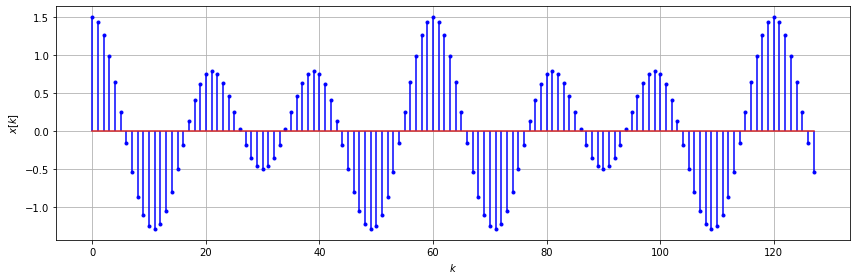

In [34]:
plt.figure(figsize=[12, 4])
k=np.arange(Nx)
plt.stem(k, x, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$x[k]$")
plt.tight_layout()

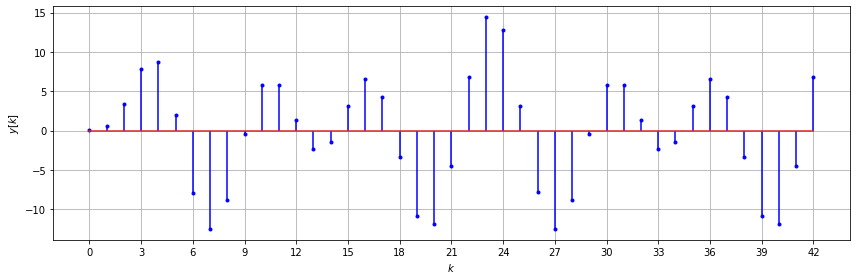

In [35]:
plt.figure(figsize=[12, 4])
k=np.arange(y.size)
plt.stem(k, y, 'b', markerfmt='b.', use_line_collection=True)
plt.grid()
plt.xticks(k[::M])
plt.xlabel("$k$")
plt.ylabel("$y[k]$")
plt.tight_layout()

In [36]:
Q=2048
X=np.fft.fftshift(np.fft.fft(x, Q))
Y=np.fft.fftshift(np.fft.fft(y, Q))
nu=np.arange(Q)/Q-0.5

In [37]:
h1=np.ones(N)
h2=np.convolve(h1, h1)
h4=np.convolve(h2, h2)/(M**4)

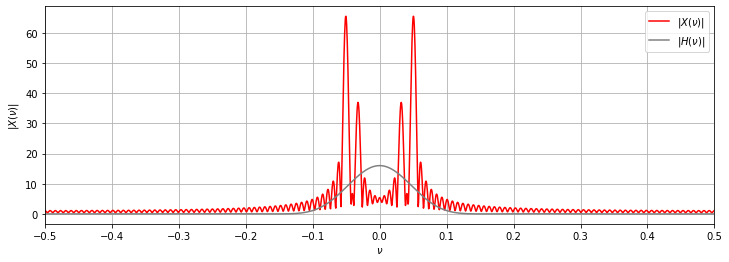

In [38]:
plt.figure(figsize=[12, 4])
plt.plot(nu, abs(X), 'r', label="$|X(\\nu)|$")
H=np.fft.fftshift(np.fft.fft(h4, Q))
plt.plot(nu, abs(H), 'grey', label="$|H(\\nu)|$")
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("$|X(\\nu)|$")
plt.legend()
plt.grid()

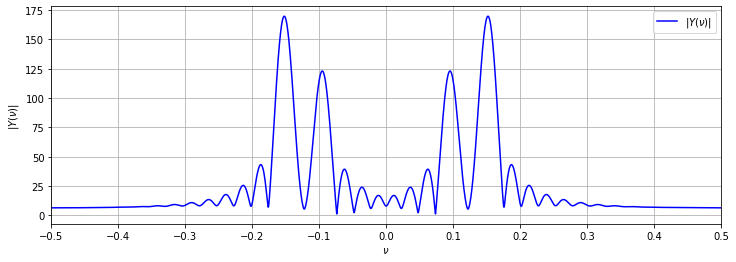

In [39]:
plt.figure(figsize=[12, 4])
plt.plot(nu, abs(Y), 'b', label="$|Y(\\nu)|$")
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("$|Y(\\nu)|$")
plt.legend()
plt.grid()

### Корректирующий фильтр 
У CIC-фильров большие искажения амплитуд гармоник в полосе пропускания. Чтобы ослабить эти искажения, можно использовать корректирующий фильтр 
$${{H}_{\text{ид}}}(\nu )={{H}_{\text{CIC}}}(\nu ){{H}_{\text{кор}}}(\nu )$$(расчет можно произвести с помощью scipy.signal.firwin2 или методом частотной выборки)


In [40]:
def ideal_passband(nu, M):
    if abs(nu)<= 1/(2*M) or abs(nu-1)<= 1/(2*M) :
        return 1+0j
    else:
        return 0+0j

In [41]:
Q=128
M=2
H_ideal = np.array([ideal_passband(nu, M) for nu in np.arange(Q)/Q], dtype=complex)
N=4
h1 = np.ones(N)/N
H_CIC =  np.fft.fft(h1, Q)
H_corr = np.zeros(Q, dtype=float)

for u in range(Q):
    if abs(H_CIC[u]) !=0:
        H_corr[u]=abs(H_ideal[u])/abs(H_CIC[u])
for u in range(Q):
    if abs(H_CIC[u]) == 0:
        H_corr[u]=(H_corr[u-1]+H_corr[u+1])/2

In [42]:
h = signal.firwin2(numtaps=64, 
               freq=np.arange(Q)[0:(Q//2+1)]/Q, 
               gain=H_corr[0:(Q//2+1)], 
               nfreqs=Q+1, 
               window='hann', 
               antisymmetric=False, 
               fs=1)

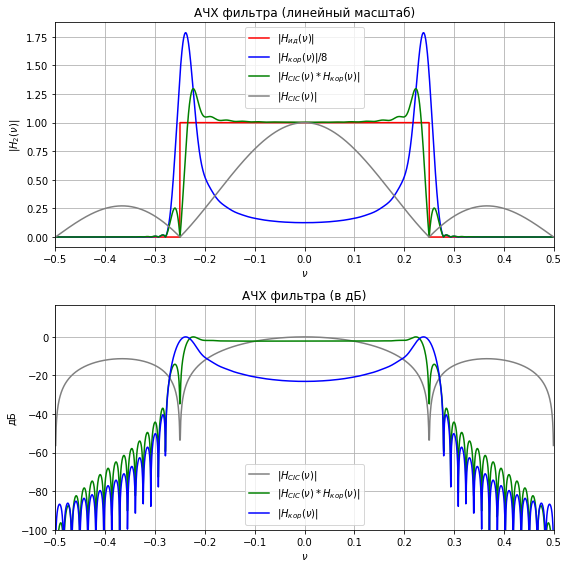

In [43]:
H_corr=np.fft.fftshift(np.fft.fft(h, 2048))
H_CIC =  np.fft.fftshift(np.fft.fft(h1, 2048))



nu=np.arange(H2.size)/H2.size-0.5
plt.figure(figsize=[8, 8])
plt.subplot(2, 1, 1)
H_ideal = np.array([ideal_passband(nu, M) for nu in np.arange(2048)/2048], dtype=complex)
plt.plot(np.arange(H_ideal.size)/H_ideal.size-0.5, abs(np.fft.fftshift(H_ideal)), 'r', label="$|H_{ид}(\\nu)|$")
plt.plot(nu, abs(H_corr)/8, 'b', label="$|H_{кор}(\\nu)|/8$")
plt.plot(nu, abs(H_corr*H_CIC), 'g', label="$|H_{CIC}(\\nu)*H_{кор}(\\nu)|$")
plt.plot(nu, abs(H_CIC), 'grey', label="$|H_{CIC}(\\nu)|$")

plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("|$H_2(\\nu)|$")
plt.title("АЧХ фильтра (линейный масштаб)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
with np.errstate(divide='ignore'):
    plt.plot(nu, 20*np.log10(abs(H_CIC)/max((abs(H_CIC)))), 'grey', label="$|H_{CIC}(\\nu)|$")
    plt.plot(nu, 20*np.log10(abs(H_corr*H_CIC)/max((abs(H_corr*H_CIC)))), 'g', label="$|H_{CIC}(\\nu)*H_{кор}(\\nu)|$")
    plt.plot(nu, 20*np.log10(abs(H_corr)/max((abs(H_corr)))), 'b', label="$|H_{кор}(\\nu)|$")
plt.xlim([-0.5, 0.5])
plt.ylim(bottom=-100)
plt.xticks(np.arange(-0.5, 0.6, 0.1))
plt.xlabel("$\\nu$")
plt.ylabel("дБ")
plt.title("АЧХ фильтра (в дБ)")
plt.legend()
plt.grid()

plt.tight_layout()

# Список литературы

* [1] Солонина А.И. Цифровая обработка сигналов в зеркале Matlab. СПб.: БХВ-Петербург, 2021. 560 c.
* [2] Signal processing (scipy.signal) — SciPy v1.8.0 Manual https://docs.scipy.org/doc/scipy/reference/signal.html
* [3] Использование CIC фильтров в задачах децимации и интерполяции сигналов http://www.dsplib.ru/content/cicid/cicid.html